# Face verification using [SphereFace](https://openaccess.thecvf.com/content_cvpr_2017/papers/Liu_SphereFace_Deep_Hypersphere_CVPR_2017_paper.pdf)


## Access Webcam for Images and Video
This notebook will go through how to access and run code on images and video taken using your webcam.

For this purpose of this tutorial we will be using DLib to do face detection on our Webcam image and video.

In [1]:
# import dependencies
from IPython.display import display, Javascript, Image
# from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import dlib
import numpy as np
import PIL
import io
import html
import time
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from sklearn import metrics

### Helper Functions
Below are a few helper function to make converting between different image data types and formats.

In [2]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
        bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def dlib2array(dlib_rect):
  """
  Params:
        dlib_rect: dlib.rectangle containing the rectangle coordinates (tl) and (br)
  Returns:
        x,y,w,h: int rectangle coordinates x, y, width, and height
  """
  x = dlib_rect.left()
  y = dlib_rect.top()
  w = dlib_rect.right() - dlib_rect.left()
  h = dlib_rect.bottom() - dlib_rect.top()
  return x, y, w, h

### [DLib](http://dlib.net/) Face Detector Classifier
For this tutorial we will run a simple face detection algorithm made using the  Histogram of Oriented Gradients (HOG) feature combined with a linear classifier [link text](https://medium.com/mlcrunch/face-detection-using-dlib-hog-198414837945), an image pyramid, and sliding window detection scheme.

In [3]:
# initialize the dlib face detection model
face_detector = dlib.get_frontal_face_detector()

### Webcam Images
Running code on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for **Camera Capture** to utilize your computer's webcam.

In [4]:
def take_photo(filename='photo.jpg'):
  cam = cv2.VideoCapture(0)
  result, img = cam.read()

  # switch red and blue color channels
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  print(img.shape)
  # get face bounding box coordinates using Haar Cascade
  faces, scores, ids = face_detector.run(img, 1, -1)
  print(faces)
  # draw face bounding box on image
  for i, d in enumerate(faces):
      print("Detection {}, score: {}, face_type:{}".format(d, scores[i], ids[i]))
      x, y, w, h = dlib2array(d)
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)
  # release the VideoCapture object, wait a second, then close the camera
  
  time.sleep(1)
  cam.release()

  return filename

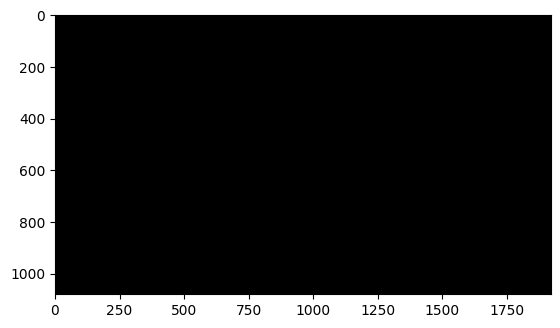

In [5]:
cam = cv2.VideoCapture(0)
result, img = cam.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)


#cam.release()

(1080, 1920, 3)
rectangles[[(913, 502) (1375, 965)], [(339, -33) (468, 110)], [(904, 449) (947, 492)], [(1606, 959) (1680, 1034)], [(1533, 900) (1576, 943)], [(1510, 799) (1573, 861)]]
Detection [(913, 502) (1375, 965)], score: 0.5436632027469122, face_type:3
Detection [(339, -33) (468, 110)], score: -0.5023544440426386, face_type:3
Detection [(904, 449) (947, 492)], score: -0.7365323007479714, face_type:4
Detection [(1606, 959) (1680, 1034)], score: -0.7728516421781664, face_type:0
Detection [(1533, 900) (1576, 943)], score: -0.9123527015545938, face_type:2
Detection [(1510, 799) (1573, 861)], score: -0.975931104229558, face_type:0
Saved to photo.jpg


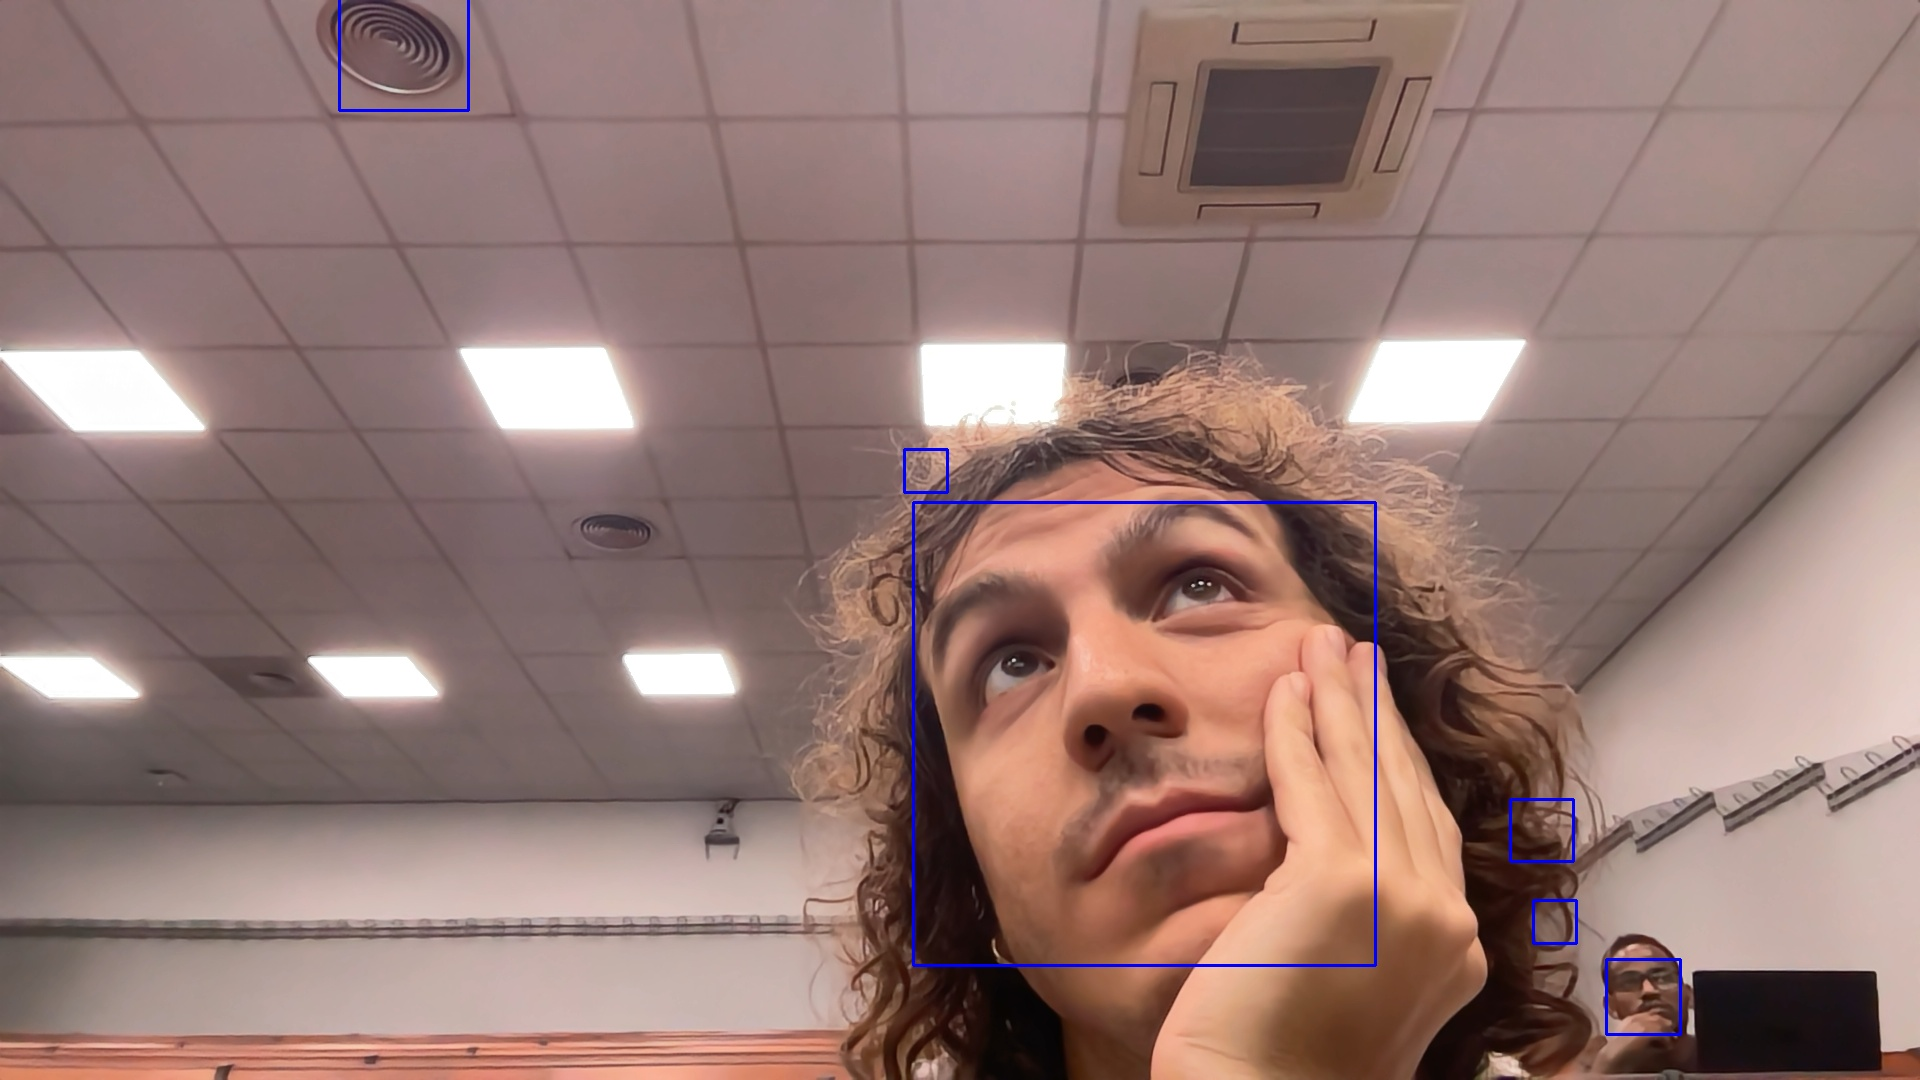

In [6]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

### Webcam Videos
Running code on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our progam (face detection) and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream.

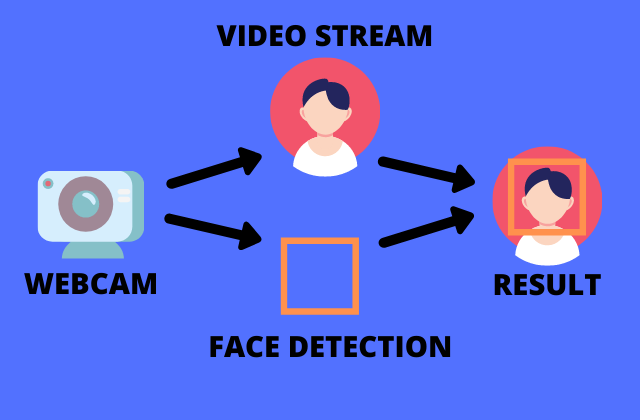</center>

In [7]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [8]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # get face region coordinates
    faces, scores, ids = face_detector.run(img, 1, -1)
    # get face bounding box for overlay
    for i, d in enumerate(faces):
      print("Detection {}, score: {}, face_type:{}".format(d, scores[i], ids[i]))
      x, y, w, h = dlib2array(d)
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

NameError: name 'eval_js' is not defined

## Evaluate SphereFace on the [LFW dataset](https://vis-www.cs.umass.edu/lfw/)
We are going to exploit an unofficial implementation of the method as the original version was implemented in Caffe.

Pretrained weights are available as a 7z file in the `model` directory.

In [12]:
!git clone https://github.com/clcarwin/sphereface_pytorch.git ./datasets/sphereface_pytorch
%cd datasets/sphereface_pytorch/
!7za x model/sphere20a_20171020.7z -omodel

Cloning into './datasets/sphereface_pytorch'...
remote: Enumerating objects: 34, done.
remote: Total 34 (delta 0), reused 0 (delta 0), pack-reused 34 (from 1)
Receiving objects: 100% (34/34), 21.11 MiB | 18.65 MiB/s, done.
Resolving deltas: 100% (8/8), done.
/Users/mirkomorello/Documents/Università/Magistrale/ICT/datasets/sphereface_pytorch
zsh:1: command not found: 7za


/Users/mirkomorello/Documents/Università/Magistrale/ICT/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Load LFW dataset

We exploit the dataset available in Pytorch vision

In [9]:
from torchvision.datasets.lfw import LFWPairs
from torchvision.transforms import Resize, Lambda, Compose

# The original images (without alignment) are downloaded
lfw = LFWPairs("./datasets", image_set='original', download=True)

# Load landmarks for face alignment
landmark = {}
with open('./datasets/sphereface_pytorch/data/lfw_landmark.txt') as f:
    landmark_lines = f.readlines()

for line in landmark_lines:
    l = line.replace('\n','').split('\t')
    landmark[l[0].split('/')[-1]] = np.array([[int(l[k]), int(l[k+1])] for k in range(1, len(l)-1, 2)])

Files already downloaded and verified


LFW contains 6,000 pairs of faces. These pairs may contain faces of the same or different identities.

In [10]:
len(lfw)
print("Matching pairs", (np.array(lfw.targets)==1).sum())
print("Non matching pairs", (np.array(lfw.targets)==0).sum())

Matching pairs 3000
Non matching pairs 3000


Let's see a pair of face images belonging to the same person (matching identity)

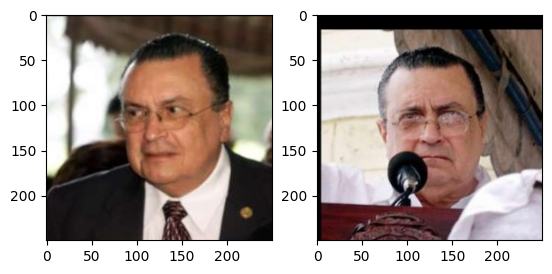

In [11]:
plt.subplot(1,2,1), plt.imshow(lfw[0][0])
plt.subplot(1,2,2), plt.imshow(lfw[0][1])
plt.show()

Let's see a pair of face images belonging to two different people (different identity)

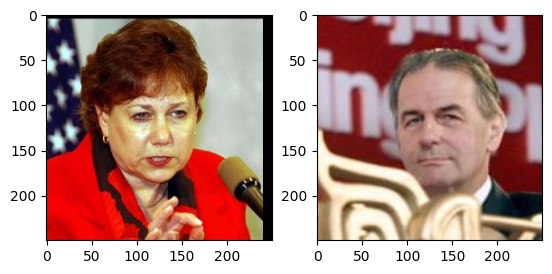

In [12]:
plt.subplot(1,2,1), plt.imshow(lfw[10][0])
plt.subplot(1,2,2), plt.imshow(lfw[100][1])
plt.show()

### Load SphereFace model
We initialize the architecture and load the pretrained weights

In [17]:
import sys
sys.path.append('./datasets/sphereface_pytorch')
from net_sphere import sphere20a

# Initialize the sphere20a architecture with feature argument that remove the classification layer
model = sphere20a(feature=True)

# Load pretrained weights
model.load_state_dict(torch.load("./datasets/sphereface_pytorch/model/sphere20a_20171020.pth"))

# Switch in eval mode
model.eval()
model

/var/folders/3t/9pfjmtv5277d5j2y93gvpb6m0000gn/T/ipykernel_55178/3048517614.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./datasets/

sphere20a(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu1_1): PReLU(num_parameters=64)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): PReLU(num_parameters=64)
  (conv1_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_3): PReLU(num_parameters=64)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu2_1): PReLU(num_parameters=128)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): PReLU(num_parameters=128)
  (conv2_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_3): PReLU(num_parameters=128)
  (conv2_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_4): PReLU(num_parameters=128)
  (conv2_5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_5): PReLU(num_parameters=128)
  (conv3_1): Conv2d(128, 256, kernel_siz

In [19]:
import cv2
from matlab_cp2tform import get_similarity_transform_for_cv2


def alignment(src_img, src_pts):
    """
    Params:
          src_img: numpy array containing the original face image
          src_pts: numpy aray containing the coordinates (x,y) of the 5 landmarks
    Returns:
          face_img: numpy array containing the aligned face according to ref_pts
    """
    ref_pts = [ [30.2946, 51.6963],[65.5318, 51.5014],
        [48.0252, 71.7366],[33.5493, 92.3655],[62.7299, 92.2041] ]
    crop_size = (96, 112)
    src_pts = np.array(src_pts).reshape(5,2)

    s = np.array(src_pts).astype(np.float32)
    r = np.array(ref_pts).astype(np.float32)

    tfm = get_similarity_transform_for_cv2(s, r)
    face_img = cv2.warpAffine(src_img, tfm, crop_size)
    return face_img


# We define the preprocessing transformations, namely:
#   1 - conversion from np.array to torch.tensor
#   2 - normalization of the pixel values
#   3 - permutation of the axis from h,w,c to c,h,w
trans = Compose([
    Lambda(lambda x: torch.from_numpy(x)),
    Lambda(lambda x: (x - 127.5 ) / 128.0),
    Lambda(lambda x: x.permute(2,0,1))
])

In [20]:
# Iterate over all dataset pairs and compute cosine similarity
cossim = torch.zeros(len(lfw))
embeddings1 = torch.zeros((len(lfw),512))
embeddings2 = torch.zeros((len(lfw),512))

with torch.no_grad():
  for i, (im1, im2, label) in enumerate(lfw):
    # landmarks corresponding to pair samples are selected
    kp1 = landmark[lfw.data[i][0].split('/')[-1]]
    kp2 = landmark[lfw.data[i][1].split('/')[-1]]

    # face is aligned and preprocessed
    im1 = trans(alignment(np.asarray(im1), kp1))
    im2 = trans(alignment(np.asarray(im2), kp2))

    # forward pass is executed on each image
    emb1 = model(im1[None])
    emb2 = model(im2[None])

    # cosine similarity is computed on image embeddings
    cossim[i] = nn.CosineSimilarity()(emb1, emb2)
    embeddings1[i] = emb1
    embeddings2[i] = emb2

/Users/mirkomorello/Documents/Università/Magistrale/ICT/matlab_cp2tform.py:312: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)


In [21]:
def KFold(n=6000, n_folds=10):
    """
    Params:
          n: int number of dataset samples
          n_folds: number of folds for cross-validation (cv)
    Returns:
          folds: list of indices for train and test of each cv fold
    """
    folds = []
    base = np.arange(n)
    for i in range(n_folds):
        test = base[int(i*n/n_folds):int((i+1)*n/n_folds)]
        train = list(set(base)-set(test))
        folds.append([train,test])
    return folds


def eval_acc(threshold, pred, actual):
    """
    Params:
          threshold: float indicating the threshold for predicted similarities
          pred: torch.tensor containing predicted similarity scores
          actual: torch.tensor containing the binary labels (1: match, 0: non-match)
    Returns:
          accuracy: float indicating the estimated accuracy
    """
    y_true = []
    y_predict = []
    for sim, gt in zip(pred, actual):
        same = 1 if float(sim) > threshold else 0
        y_predict.append(same)
        y_true.append(int(gt))
    y_true = np.array(y_true)
    y_predict = np.array(y_predict)
    accuracy = 1.0*np.count_nonzero(y_true==y_predict)/len(y_true)
    return accuracy


def find_best_threshold(thresholds, predicts, actual):
    best_threshold = best_acc = 0
    for threshold in thresholds:
        accuracy = eval_acc(threshold, predicts, actual)
        if accuracy >= best_acc:
            best_acc = accuracy
            best_threshold = threshold
    return best_threshold

In [22]:
accuracy = []
thd = []
folds = KFold(n=6000, n_folds=10)
thresholds = np.arange(-1.0, 1.0, 0.005)
actual = np.asarray(lfw.targets)

for idx, (train, test) in enumerate(folds):
    best_thresh = find_best_threshold(thresholds, cossim[train], actual[train])
    accuracy.append(eval_acc(best_thresh, cossim[test], actual[test]))
    thd.append(best_thresh)
print('LFWACC={:.4f} std={:.4f} thd={:.4f}'.format(np.mean(accuracy), np.std(accuracy), np.mean(thd)))

LFWACC=0.9812 std=0.0043 thd=0.3200


## Assignment 1: Retrieve the face of the identity in the LFW dataset most similar to your face
1. Select an image per identity from the LFW dataset
2. Encode each one of the selected images and store embeddings
3. Capture your face
4. Encode your face
5. Calculate the cosine similarity between your face encoding and all image encodings selected by the LFW
6. Sort similarity scores in descending order and retrieve the face of the most similar identity

In [28]:
from glob import glob
from PIL import Image

filenames = glob('./datasets/lfw-py/lfw/**/*.jpg')

embed = torch.zeros((len(filenames), 512))

transform = Compose([
  Lambda(lambda x: cv2.resize(np.array(x), (96, 112))),
  Lambda(lambda x: torch.from_numpy(np.asarray(x))),
  Lambda(lambda x: (x - 127.5 ) / 128.0),
  Lambda(lambda x: x.permute(2,0,1))
])

with torch.no_grad():
  for i, filename in enumerate(filenames):
    img = transform(Image.open(filename))
    embed[i] = model(img[None])

In [32]:
# print all the embeddings for each person in the dataset
embeddings = embed.numpy()
embeddings, embeddings.shape


(array([[-0.00028489, -0.00794752,  0.00935287, ..., -0.01994991,
          0.00121378, -0.00796091],
        [-0.02851617,  0.01103292,  0.00284748, ..., -0.00414645,
          0.05391749,  0.01700558],
        [-0.00025468, -0.00073839,  0.01092911, ..., -0.00275493,
          0.0189353 , -0.01479267],
        ...,
        [-0.03548198,  0.02036801,  0.00884883, ...,  0.0170186 ,
          0.01112348,  0.00854435],
        [ 0.02213819,  0.04481578, -0.00742324, ..., -0.03885282,
          0.03986568, -0.05288939],
        [ 0.03803474,  0.02920831, -0.01929213, ..., -0.02445004,
          0.00713426, -0.02330586]], dtype=float32),
 (13233, 512))

## Assigment 2: Check whether face embeddings belonging to the same identity aggregate into clusters

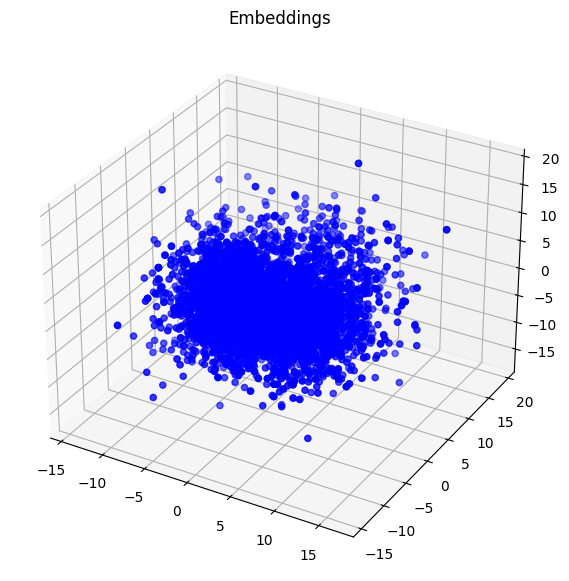

In [ ]:
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA

x, y, z = np.hsplit(PCA(n_components=3).fit_transform(embeddings1), 3)

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(x, y, z, color = "blue")
plt.title("Embeddings")

# show plot
plt.show()